In [3]:
# Setup environment
%run 0-Environment_Setup.ipynb

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
Stored 's3_datalake_path_csv' (str)
Stored 'local_data_path_csv' (str)
Stored 's3_datalake_path_parquet' (str)


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Normalization, Flatten, Dropout 
from tensorflow.keras.layers import Concatenate, GaussianNoise, Lambda
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, RNN, GRU
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

2024-10-11 17:55:08.524441: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 17:55:08.732304: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 17:55:08.759634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 17:55:08.799441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 17:55:08.809855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 17:55:08.851516: I tensorflow/core/platform/cpu_feature_gu

In [9]:
# Create a temporary directory for saving data
local_path = f"{os.getcwd()}/tmp"
if not os.path.exists(local_path):
    os.makedirs(local_path)

In [5]:
# Set session variables
from sagemaker.tensorflow import TensorFlow

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_session.region_name
bucket = sess.default_bucket()

train_prefix = "store-sales-forecasting/train"
test_prefix = "store-sales-forecasting/test"
val_prefix = "store-sales-forecasting/val"

In [12]:
# Load data splits for testing in notebook
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=train_prefix)
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=test_prefix)
sagemaker_session.download_data(path=local_path, bucket=bucket, key_prefix=val_prefix)

continuous_train_inputs = np.load(os.path.join(local_path, 'continuous_train_inputs.npy'))
categorical_train_inputs = np.load(os.path.join(local_path, 'categorical_train_inputs.npy'))
train_targets = np.load(os.path.join(local_path, 'train_targets.npy'))

continuous_test_inputs = np.load(os.path.join(local_path, 'continuous_test_inputs.npy'))
categorical_test_inputs = np.load(os.path.join(local_path, 'categorical_test_inputs.npy'))
test_targets = np.load(os.path.join(local_path, 'test_targets.npy'))

continuous_val_inputs = np.load(os.path.join(local_path, 'continuous_val_inputs.npy'))
categorical_val_inputs = np.load(os.path.join(local_path, 'categorical_val_inputs.npy'))
val_targets = np.load(os.path.join(local_path, 'val_targets.npy'))

global_mean = np.load(os.path.join(local_path, 'global_mean.npy'))
global_stddev = np.load(os.path.join(local_path, 'global_stddev.npy'))

print(continuous_train_inputs.shape)
print(categorical_train_inputs.shape)
print(train_targets.shape)
print(continuous_test_inputs.shape)
print(categorical_test_inputs.shape)
print(test_targets.shape)
print(continuous_val_inputs.shape)
print(categorical_val_inputs.shape)
print(val_targets.shape)
print(global_mean)
print(global_stddev)

(1003, 54, 7, 3)
(1003, 54, 7, 15)
(1003, 54, 1)
(330, 54, 7, 3)
(330, 54, 7, 15)
(330, 54, 1)
(330, 54, 7, 3)
(330, 54, 7, 15)
(330, 54, 1)
[9754.29461184   83.15427319   11.49229923]
[8771.22271946   22.17583982   29.16430315]


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 7, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_2    │ (None, 54, 7, 3)  │          0 │ continuous_input… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 7, 15) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 54, 7, 18) │          0 │ gaussian_noise_2… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 378, 18)   │          0 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 8)         │        864 │ reshape_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8)         │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 54)        │        486 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 54, 1)     │          0 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,350 (5.27 KB)

 Trainable params: 1,350 (5.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2024-10-11 18:17:55.317924: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22748040 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 0.9762 - mean_absolute_error: 0.6560 - root_mean_squared_error: 0.9679 - val_loss: 1.7392 - val_mean_absolute_error: 0.7669 - val_root_mean_squared_error: 1.3110
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.4916 - mean_absolute_error: 0.4159 - root_mean_squared_error: 0.6882 - val_loss: 1.2244 - val_mean_absolute_error: 0.6156 - val_root_mean_squared_error: 1.1012
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.4245 - mean_absolute_error: 0.3936 - root_mean_squared_error: 0.6419 - val_loss: 0.9445 - val_mean_absolute_error: 0.5156 - val_root_mean_squared_error: 0.9663
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.3459 - mean_absolute_error: 0.3440 - root_mean_squared_error: 0.5747 - val_loss: 0.8246 - val_mean_absolute_error: 0.4757 - val_root_mean_squared_error: 0.9022
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.3255 - mean_absolute_error: 0.3401 - root_mean_squared_error: 0.

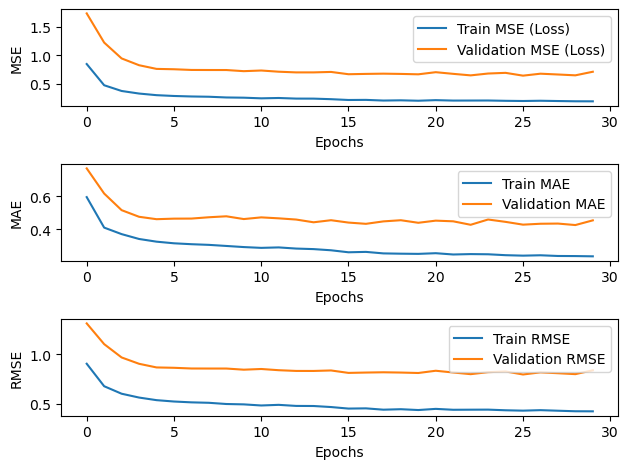

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5529 - mean_absolute_error: 0.4495 - root_mean_squared_error: 0.7351


In [18]:
# LSTM model
lstm_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=continuous_train_inputs.shape[1:], 
    name="continuous_input"
)

categorical_input = Input(
    shape=categorical_train_inputs.shape[1:], 
    name="categorical_input"
)

noisy_input = GaussianNoise(stddev=0.3)(continuous_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, combined_inputs.shape[3]))(combined_inputs)
lstm = LSTM(8, kernel_regularizer=tf.keras.regularizers.l2(0.002))(reshaped)
dropout = Dropout(0.2)(lstm)
dense = Dense(train_targets.shape[1] * train_targets.shape[2])(dropout)
outputs = Reshape(target_shape=(train_targets.shape[1], train_targets.shape[2]))(dense)

lstm_model = Model(inputs=[continuous_input, categorical_input], outputs=outputs)

lstm_model.compile(
    loss='mean_squared_error', 
    metrics=['root_mean_squared_error', 'mean_absolute_error'], 
    optimizer=tf.keras.optimizers.Adam(0.002)
)

print(lstm_model.summary())


history = lstm_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=10, 
    callbacks=[lstm_es_callback]
)

fig, axs = plt.subplots(3)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

eval = lstm_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ continuous_input    │ (None, 54, 7, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_4    │ (None, 54, 7, 3)  │          0 │ continuous_input… │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 54, 7, 15) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 54, 7, 18) │          0 │ gaussian_noise_4… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 378, 18)   │          0 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 8)         │        672 │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8)         │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 54)        │        486 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 54, 1)     │          0 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,158 (4.52 KB)

 Trainable params: 1,158 (4.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50


2024-10-11 18:26:44.598392: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22748040 exceeds 10% of free system memory.


101/101 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 0.9148 - mean_absolute_error: 0.6305 - root_mean_squared_error: 0.9375 - val_loss: 1.4049 - val_mean_absolute_error: 0.6627 - val_root_mean_squared_error: 1.1790
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - loss: 0.4167 - mean_absolute_error: 0.3949 - root_mean_squared_error: 0.6347 - val_loss: 0.9880 - val_mean_absolute_error: 0.5285 - val_root_mean_squared_error: 0.9889
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - loss: 0.3222 - mean_absolute_error: 0.3541 - root_mean_squared_error: 0.5584 - val_loss: 0.8415 - val_mean_absolute_error: 0.4787 - val_root_mean_squared_error: 0.9121
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 0.2511 - mean_absolute_error: 0.3125 - root_mean_squared_error: 0.4894 - val_loss: 0.7717 - val_mean_absolute_error: 0.4615 - val_root_mean_squared_error: 0.8731
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - loss: 0.2718 - mean_absolute_error: 0.3176 - root_mean

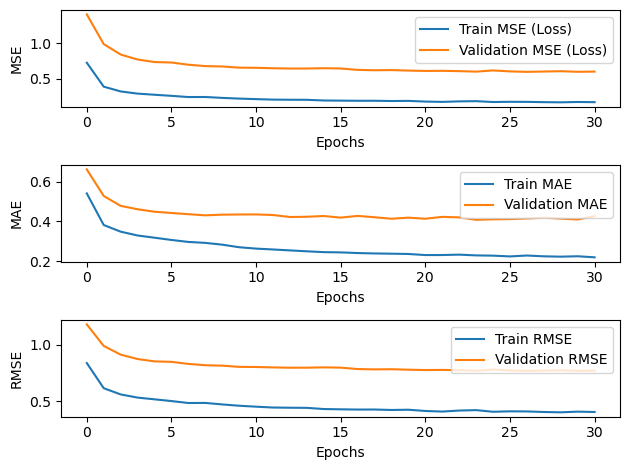

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.5172 - mean_absolute_error: 0.4267 - root_mean_squared_error: 0.7114


In [20]:
# GRU model
gru_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    verbose=1,
    restore_best_weights=True
)


continuous_input = Input(
    shape=continuous_train_inputs.shape[1:], 
    name="continuous_input"
)

categorical_input = Input(
    shape=categorical_train_inputs.shape[1:], 
    name="categorical_input"
)

noisy_input = GaussianNoise(stddev=0.3)(continuous_input)
combined_inputs = Concatenate(axis=-1)([noisy_input, categorical_input])
reshaped = Reshape(target_shape=(-1, combined_inputs.shape[3]))(combined_inputs)
gru = GRU(8, kernel_regularizer=tf.keras.regularizers.l2(0.002))(reshaped)
dropout = Dropout(0.2)(gru)
dense = Dense(train_targets.shape[1] * train_targets.shape[2])(dropout)
outputs = Reshape(target_shape=(train_targets.shape[1], train_targets.shape[2]))(dense)

gru_model = Model(inputs=[continuous_input, categorical_input], outputs=outputs)

gru_model.compile(
    loss='mean_squared_error', 
    metrics=['root_mean_squared_error', 'mean_absolute_error'], 
    optimizer=tf.keras.optimizers.Adam(0.002)
)

print(gru_model.summary())


history = gru_model.fit(
    [continuous_train_inputs, categorical_train_inputs], 
    train_targets, 
    validation_data=([continuous_test_inputs, categorical_test_inputs], test_targets), 
    epochs=50, 
    batch_size=10, 
    callbacks=[gru_es_callback]
)

fig, axs = plt.subplots(3)
axs[0].plot(history.history['loss'], label='Train MSE (Loss)')
axs[0].plot(history.history['val_loss'], label='Validation MSE (Loss)')
axs[1].plot(history.history['mean_absolute_error'], label='Train MAE')
axs[1].plot(history.history['val_mean_absolute_error'], label='Validation MAE')
axs[2].plot(history.history['root_mean_squared_error'], label='Train RMSE')
axs[2].plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('RMSE')
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

eval = gru_model.evaluate([continuous_val_inputs, categorical_val_inputs], val_targets)

In [76]:
# Generate predicitons for the validation set
predictions = gru_model.predict([continuous_val_inputs, categorical_val_inputs])

# Denormalize to the original scale of the data
targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
predictions_denormalized = predictions * global_stddev[0] + global_mean[0]

targets_flat = targets_denormalized.flatten()
predictions_flat = predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': targets_flat, 'predicted_sales': predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(targets_flat, predictions_flat)
mae = mean_absolute_error(targets_flat, predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


store_nbr  actual_sales  predicted_sales
7800          24      14601.69     10494.881836
15948         18       7301.02      9385.046875
3348           0       5618.85      8628.718750
9806          32       8711.52     11138.320312
4285          19      15708.54      7288.063477
1346          50      14961.05     24080.976562
2394          18      10638.56      9152.782227
13345          7      16566.38     22930.808594
16535         11       7438.07      8456.371094
16861         13      12961.23      8958.286133
3309          15       5906.95     10466.853516
887           23      17980.65     17910.830078
6871          13       6753.43      7481.130859
7333          43      37197.46     42015.140625
17389          1      11304.55     15235.937500
13396          4      10728.03     12801.401367
2435           5      15697.04     17597.560547
13106         38      22364.61     17013.324219
5624           8      38880.53     22273.062500
14027         41      12089.18      3610.931152

RMSE: 6597.9534027771515 MAE: 3773.0932920711016


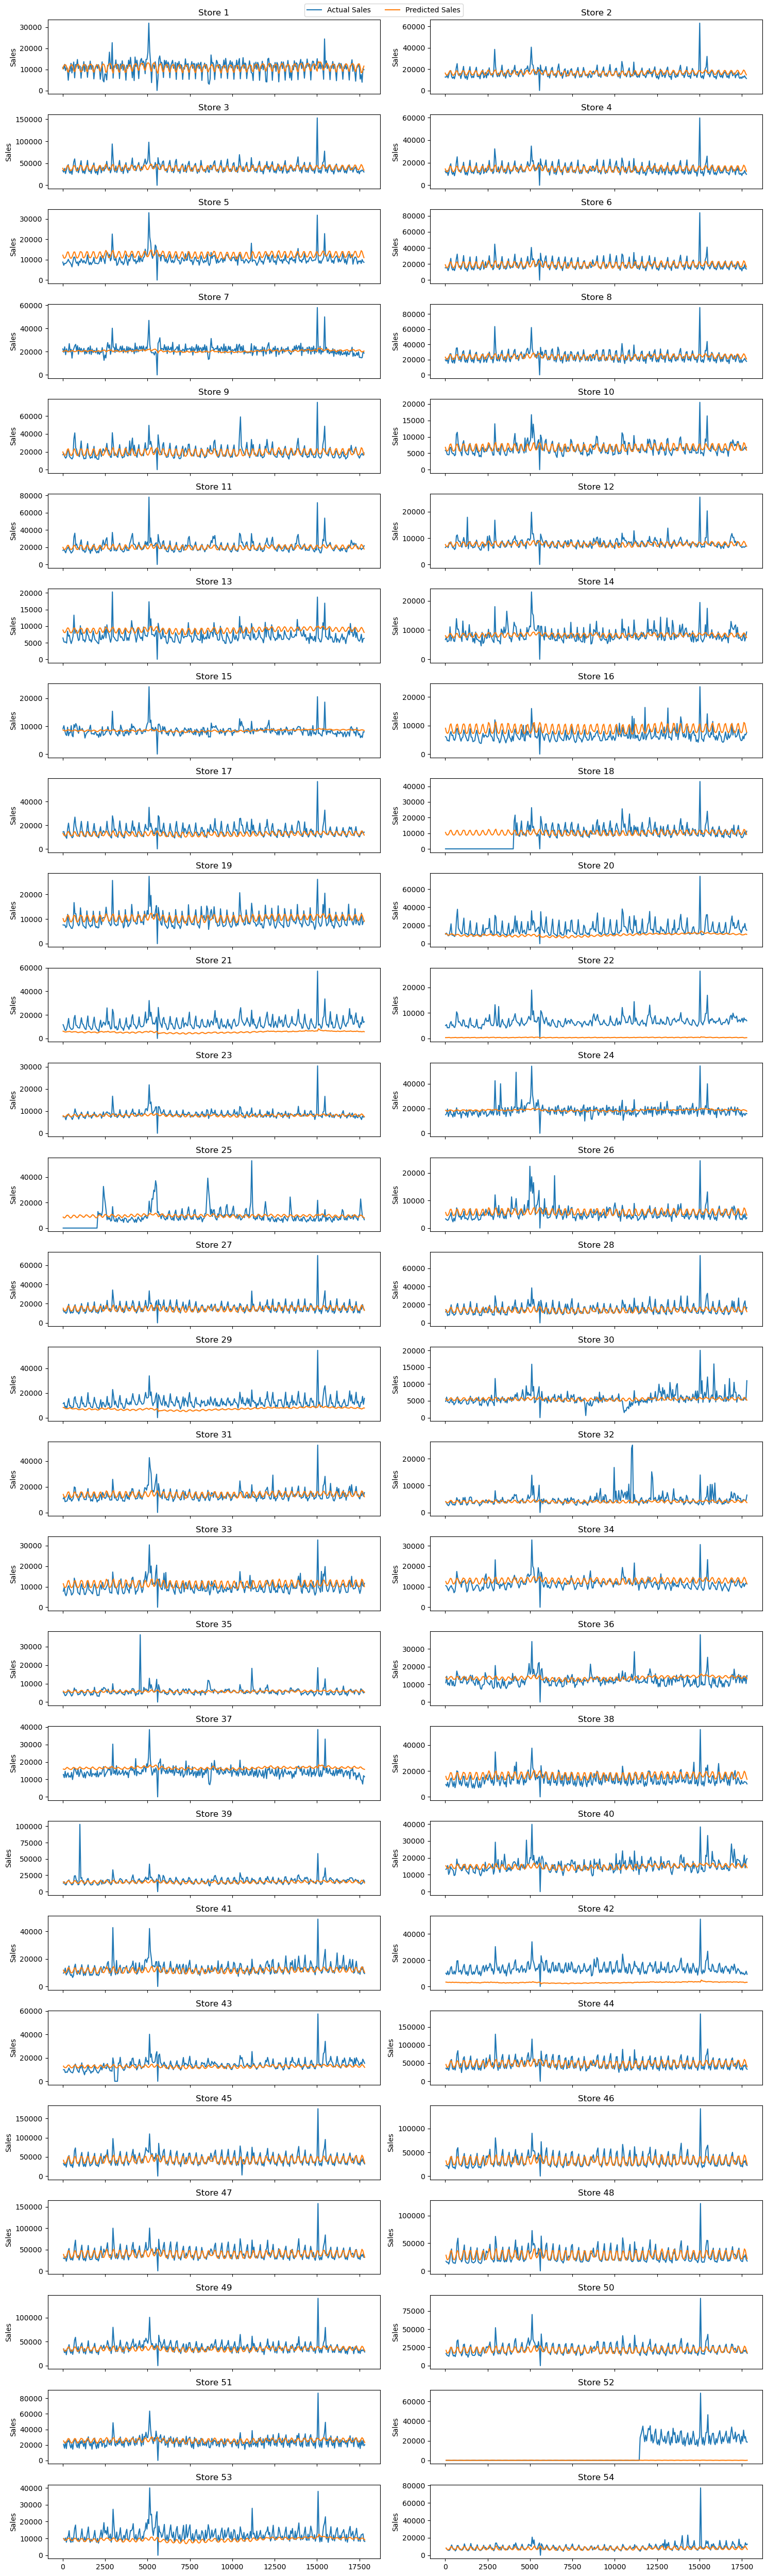

In [34]:
fig, axs = plt.subplots(27, 2, figsize=(15, 50), sharex=True)
axs = axs.ravel()
for i in range(54):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

## Experiment: Train a model on the residuals for each store

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
# Generate predictions from the training set and calculate residuals (error) 
train_predictions = gru_model.predict([continuous_train_inputs, categorical_train_inputs])
train_residuals = train_targets - train_predictions

# Join the inputs back together
train_inputs = np.concatenate((continuous_train_inputs, categorical_train_inputs), axis=-1)
print(train_inputs.shape)

# Aggregate the days in each window
aggregated_train_inputs = np.mean(train_inputs, axis=2)

print(train_predictions.shape)
print(train_residuals.shape)
print(aggregated_train_inputs.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
(1003, 54, 7, 18)
(1003, 54, 1)
(1003, 54, 1)
(1003, 54, 18)


In [92]:
# For each store, train a random forest regressor on the residuals
store_residual_models = {}
n_estimators_per_tree = 10

for i in range(54):
    store_train_inputs = aggregated_train_inputs[:, i, :]
    store_train_residuals = train_residuals[:, i]

    store_residual_model = RandomForestRegressor(n_estimators=n_estimators_per_tree)
    store_residual_model.fit(store_train_inputs, store_train_residuals.squeeze())

    store_residual_models[i] = store_residual_model


store_residual_models[0]

RandomForestRegressor(n_estimators=10)

In [78]:
val_targets.shape

(330, 54, 1)

In [93]:
# Generate predictions and residuals for the validation set
val_predictions = gru_model.predict([continuous_val_inputs, categorical_val_inputs])
val_residuals = val_targets - val_predictions

# Join the inputs back together
val_inputs = np.concatenate((continuous_val_inputs, categorical_val_inputs), axis=-1)
print(val_inputs.shape)

# Aggregate across days
aggregated_val_inputs = np.mean(val_inputs, axis=2)

print(val_predictions.shape)
print(val_residuals.shape)
print(aggregated_val_inputs.shape)

# Set a placeholder for the residual tree predictions
residual_model_predictions = np.zeros((val_residuals.shape[0], val_residuals.shape[1]))

# For each store, use the tree trained on the errors for that store to correct model predictions
for i in range(54):
    store_val_inputs = aggregated_val_inputs[:, i, :]
    store_predictions = store_residual_models[i].predict(store_val_inputs)
    residual_model_predictions[:, i] = store_predictions

print(residual_model_predictions.shape)

# Correct the original model predictions
ensemble_predictions = val_predictions.squeeze() + residual_model_predictions

# Denormalize the true targets and predictions
val_targets_denormalized = val_targets * global_stddev[0] + global_mean[0]
ensemble_predictions_denormalized = ensemble_predictions * global_stddev[0] + global_mean[0]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
(330, 54, 7, 18)
(330, 54, 1)
(330, 54, 1)
(330, 54, 18)
(330, 54)


In [94]:
val_targets_flat = val_targets_denormalized.flatten()
ensemble_predictions_flat = ensemble_predictions_denormalized.flatten()

# Join the predictions and actual sales values for each store/date into a dataframe
n = ensemble_predictions_denormalized.shape[0]
store_numbers = list(range(54)) * n
predictions_df = pd.DataFrame({'store_nbr': store_numbers, 'actual_sales': val_targets_flat, 'predicted_sales': ensemble_predictions_flat})

# View a random sample of 20 predicted vs actual sales values
display(predictions_df.sample(20))

# Compute RMSE and MAE on the original scale
rmse = root_mean_squared_error(val_targets_flat, ensemble_predictions_flat)
mae = mean_absolute_error(val_targets_flat, ensemble_predictions_flat)
print(f"RMSE: {rmse} MAE: {mae}")

store_nbr  actual_sales  predicted_sales
3723          51          0.00       -85.785500
7512           6      23104.74     29441.752638
15730         16      15520.13     16181.287546
6368          50      30839.61     16349.230744
14083         43      47669.79     40182.940754
16372         10      15398.09     19479.815286
10474         52      16881.38     10356.594256
9286          52      10562.67      9457.283905
566           26      10383.81      7556.763481
16507         37      18700.44     17820.686000
10360         46      28412.94     22074.953754
11768         50      19822.31     11587.477413
16489         19      17265.47     26072.553125
12565         37      12274.34     12329.421914
7163          35       9930.63     15671.762573
7517          11       7139.50     10844.546573
11644         34       7563.80      6714.690788
4163           5      17945.10     15118.286548
16893         45      42263.54     36260.497968
12632         50      18240.78     18130.679869

RMSE: 7723.339120019614 MAE: 4784.808516819044


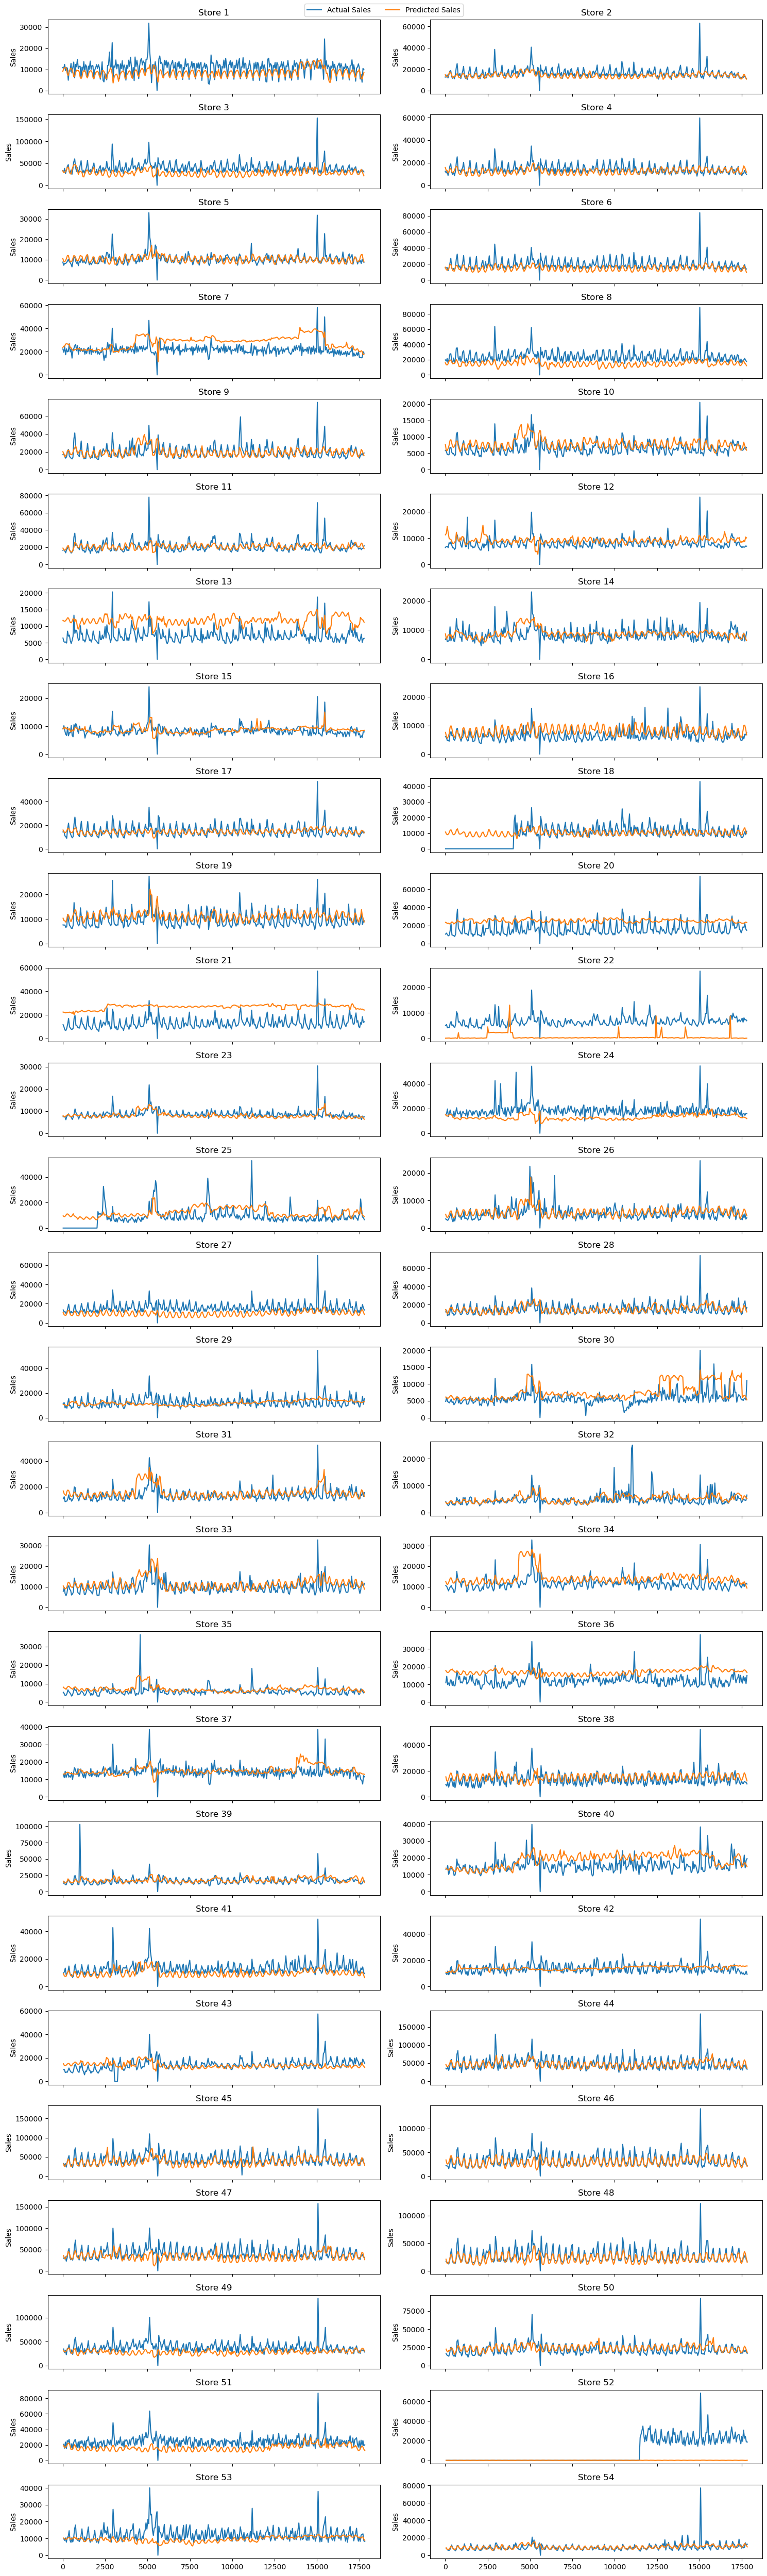

In [95]:
fig, axs = plt.subplots(27, 2, figsize=(15, 50), sharex=True)
axs = axs.ravel()
for i in range(54):
    ax = axs[i]
    store_data = predictions_df[predictions_df["store_nbr"] == i]

    ax.plot(store_data.index, store_data['actual_sales'], label='Actual Sales')
    ax.plot(store_data.index, store_data['predicted_sales'], label='Predicted Sales')

    ax.set_title(f"Store {i+1}")
    ax.set_ylabel("Sales")

fig.legend(['Actual Sales', 'Predicted Sales'], loc='upper center', ncol=2)
plt.tight_layout()
plt.show()

## Estimator

In [36]:
estimator = TensorFlow(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='2.6',
    py_version='py38',
    hyperparameters={
        'batch_size': 10,
        'epochs': 50,
        'learning_rate': 0.002,
        'units': 8,
        'noise': 0.3,
        'l2_regularization': 0.004,
        'dropout': 0.2
    },
    output_path=f's3://{sagemaker_session.default_bucket()}/store-sales-forecasting/training-output/'
)

estimator.fit({
    'train': f"s3://{sagemaker_session.default_bucket()}/{train_prefix}", 
    'test':  f"s3://{sagemaker_session.default_bucket()}/{test_prefix}", 
    'validation':  f"s3://{sagemaker_session.default_bucket()}/{val_prefix}"
})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2024-10-11-18-55-53-963


2024-10-11 18:55:54 Starting - Starting the training job...
2024-10-11 18:56:10 Starting - Preparing the instances for training...
2024-10-11 18:56:37 Downloading - Downloading input data...
2024-10-11 18:57:03 Downloading - Downloading the training image...
2024-10-11 18:57:54 Training - Training image download completed. Training in progress...2024-10-11 18:57:59.087610: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-11 18:57:59.087784: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2024-10-11 18:57:59.114675: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2024-10-11 18:58:00,334 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2024-10-11 18:58:00,344 sagemaker-training-toolkit INFO     